# Analysis of Helsinki city bike usage in different districts in 2019

For plotting please install `mapclassify` for the quantiles scheme in matplotlib and `bokeh` for interactive maps.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, LogColorMapper
from bokeh.models.widgets import Panel, Tabs
import bokeh.palettes
output_notebook()

Loading BokehJS ...

In [3]:
rides = pd.read_csv("rides_between_districts_full.csv")
rides = rides.drop(columns=["Unnamed: 0"])
rides = rides.astype({"start_district": str, "finish_district": str, "count": int}).replace({"start_district": "0", "finish_district": "0"},"000")
rides

start_district finish_district  count  total_distance  total_duration  \
0                000             101     10        100128.0         26429.0   
1                000             101     10         99219.0         26495.0   
2                000             101      7         72213.0         19102.0   
3                000             101      4         34739.0          9277.0   
4                000             101     50        436330.0        119183.0   
...              ...             ...    ...             ...             ...   
11813            702             702     11          6161.0          1616.0   
11814            702             702    292        180529.0         48403.0   
11815            702             702    212        132183.0         36174.0   
11816            702             702    145        100320.0         25890.0   
11817            702             702     25         17134.0          4827.0   

       day     time  
0      0.0      day  
1      0.0  evening  
2      0.0  morning  
3      0.0    night  
4      1.0      day  
...    ...      ...  
11813  5.0    night  
11814  6.0      day  
11815  6.0  evening  
11816  6.0  morning  
11817  6.0    night  

[11818 rows x 7 columns]

In [4]:
helsinki = gpd.read_file("data/Helsingin_peruspiirit.geojson")
helsinki = helsinki.drop(columns=["kokotunnus", "kunta"])
helsinki

id           name                                           geometry
0   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...
1   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...
2   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...
3   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...
4   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...
5   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...
6   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...
7   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...
8   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...
9   205        Kaarela  POLYGON ((25490791.048 6682458.057, 25490844.3...
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...
17  403   Tuomarinkylä  POLYGON ((25494378.997 6683957.050, 25494349.5...
18  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...
19  405     Itä-Pakila  POLYGON ((25497068.756 6681137.092, 25497069.3...
20  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...
21  502      Pukinmäki  POLYGON ((25498428.710 6681094.513, 25498428.7...
22  503          Malmi  POLYGON ((25499756.109 6681137.768, 25499753.4...
23  504      Suutarila  POLYGON ((25498644.567 6683722.393, 25498644.5...
24  505       Puistola  POLYGON ((25500835.716 6685958.592, 25500844.3...
25  506       Jakomäki  POLYGON ((25503440.681 6682129.409, 25503430.1...
26  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...
27  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...
28  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...
29  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...
30  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...
31  703     Mellunkylä  POLYGON ((25501995.441 6680333.298, 25502017.6...
32  704       Vuosaari  POLYGON ((25504854.051 6675200.255, 25504837.3...
33  801    Östersundom  POLYGON ((25507738.603 6680990.840, 25507699.0...

In [5]:
espoo = gpd.read_file("data/Espoo_alue.geojson")
espoo["id"] = "000"
espoo = espoo.rename(columns={"KAUPUNKI": "name"})
espoo["name"] = espoo["name"].str.title()
espoo = espoo[["id", "name", "geometry"]]
espoo

id   name                                           geometry
0  000  Espoo  POLYGON ((2765665.222 8436783.461, 2765666.558...

In [6]:
espoo = espoo.to_crs(helsinki.crs)
districts = helsinki.append(espoo)
districts = districts.sort_values("id").reset_index(drop=True)
districts["center"] = districts["geometry"].centroid
districts

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  205        Kaarela  POLYGON ((25490791.048 6682458.057, 25490844.3...   
11  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
12  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
13  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
14  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
15  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
16  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
17  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
18  403   Tuomarinkylä  POLYGON ((25494378.997 6683957.050, 25494349.5...   
19  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
20  405     Itä-Pakila  POLYGON ((25497068.756 6681137.092, 25497069.3...   
21  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
22  502      Pukinmäki  POLYGON ((25498428.710 6681094.513, 25498428.7...   
23  503          Malmi  POLYGON ((25499756.109 6681137.768, 25499753.4...   
24  504      Suutarila  POLYGON ((25498644.567 6683722.393, 25498644.5...   
25  505       Puistola  POLYGON ((25500835.716 6685958.592, 25500844.3...   
26  506       Jakomäki  POLYGON ((25503440.681 6682129.409, 25503430.1...   
27  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
28  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
29  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
30  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
31  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   
32  703     Mellunkylä  POLYGON ((25501995.441 6680333.298, 25502017.6...   
33  704       Vuosaari  POLYGON ((25504854.051 6675200.255, 25504837.3...   
34  801    Östersundom  POLYGON ((25507738.603 6680990.840, 25507699.0...   

                              center  
0   POINT (25484122.085 6672350.503)  
1   POINT (25498078.279 6673007.924)  
2   POINT (25494952.297 6665184.353)  
3   POINT (25495104.409 6672307.919)  
4   POINT (25495573.889 6674531.579)  
5   POINT (25492722.598 6671426.352)  
6   POINT (25494271.958 6675422.451)  
7   POINT (25492472.715 6675525.331)  
8   POINT (25494058.597 6678788.226)  
9   POINT (25491965.151 6679471.801)  
10  POINT (25493370.083 6681778.742)  
11  POINT (25498093.689 6674563.543)  
12  POINT (25496890.525 6675201.131)  
13  POINT (25498106.463 6675861.594)  
14  POINT (25495991.386 6677071.942)  
15  POINT (25497991.186 6677588.383)  
16  POINT (25495850.152 6679485.986)  
17  POINT (25496177.795 6680978.798)  
18  POINT (25496227.536 6683275.165)  
19  POINT (25498082.278 6679808.826)  
20  POINT (25497919.652 6681978.538)  
21  POINT (25500637.196 6678899.085)  
22  POINT (25499229.148 6681344.796)  
23  POINT (25501032.853 6682292.444)  
24  POINT (25499944.750 6684699.125)  
25  POINT (25502623.193 6684213.279)  
26  POINT (25504335.596 6682942.943)  
27  POINT (25500070.452 6674641.203)  
28  POINT (25502300.276 6676236.014)  
29  POINT (25503023.772 6659134.401)  
30  POINT (25505053.309

<AxesSubplot:>

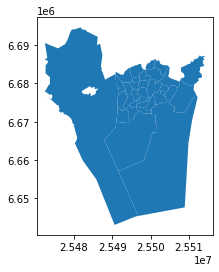

In [7]:
districts.plot()

## Outgoing ride statistics for every district

In [9]:
rides

start_district finish_district  count  total_distance  total_duration  \
0                000             101     10        100128.0         26429.0   
1                000             101     10         99219.0         26495.0   
2                000             101      7         72213.0         19102.0   
3                000             101      4         34739.0          9277.0   
4                000             101     50        436330.0        119183.0   
...              ...             ...    ...             ...             ...   
11813            702             702     11          6161.0          1616.0   
11814            702             702    292        180529.0         48403.0   
11815            702             702    212        132183.0         36174.0   
11816            702             702    145        100320.0         25890.0   
11817            702             702     25         17134.0          4827.0   

       day     time  
0      0.0      day  
1      0.0  evening  
2      0.0  morning  
3      0.0    night  
4      1.0      day  
...    ...      ...  
11813  5.0    night  
11814  6.0      day  
11815  6.0  evening  
11816  6.0  morning  
11817  6.0    night  

[11818 rows x 7 columns]

In [11]:
df_out = rides[rides["start_district"] != rides["finish_district"]]
df_out = df_out.rename(columns={"start_district": "id"})
df_out = df_out.groupby("id", as_index=False).sum()
df_out = pd.merge(districts, df_out, on="id")
df_out

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

     count  total_distance  total_duration     day  
0    37279     185098916.0      48952915.0  1285.0  
1   337922     730013035.0     211669081.0  1700.0  
2   193674     427688900.0     121260043.0  1505.0  
3   371533     868463167.0     249072501.0  1663.0  
4   168213     402354231.0     113108179.0  1644.0  
5    61651     223493787.0      61181856.0  1095.0  
6   120493     369797428.0     100825498.0  1615.0  
7    56147     181339095.0      50173932.0  1419.0  
8    36472     124042397.0      33871317.0  1546.0  
9    21991      73207639.0      19593730.0  1245.0  
10  219254     550443624.0     156969183.0  1821.0  
11  109825     249473297.0      68180681.0  1714.0  
12  141619     339371410.0      93527571.0  1818.0  
13   85778     228606065.0      63224953.0  1698.0  
14   89002     281928281.0      78636357.0  1800.0  
15    5576      20007582.0       5572959.0  1271.0  
16    1748       6808547.0       1856680.0   888.0  
17   15188      53917512.0      14828984.0  1396.0  
18   16422      70733319.0      19596237.0  1453.0  
19   16915      54480049.0      14665928.0  1301.0  
20   30799     109515821.0      29741231.0  1369.0  
21    6040      22720926.0       6212434.0   705.0  
22   13329      39564605.0      10982651.0   989.0  
23    5504      14917834.0       3792779.0   596.0

Let us plot this using quantiles. Basically, uneven intervals for the values we plot decided by the program. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_out.plot(ax=ax1, column='count', legend=True, scheme='quantiles')
ax1.set_title("Outgoing ride counts per district")
df_out.plot(ax=ax2, column='total_distance', legend=True, scheme='quantiles')
ax2.set_title("Outgoing total ride distance per district")

To get a better idea of the distribution, we can also plot this using equal intervals.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_out.plot(ax=ax1, column='count', legend=True, scheme='equal_interval')
ax1.set_title("Outgoing ride counts per district")
df_out.plot(ax=ax2, column='total_distance', legend=True, scheme='equal_interval')
ax2.set_title("Outgoing total ride distance per district")

## Incoming ride statistics for every district

In [16]:
df_in = rides[rides["start_district"] != rides["finish_district"]]
df_in = df_in.rename(columns={"finish_district": "id"})
df_in = df_in.groupby("id").sum()
df_in = pd.merge(districts, df_in, on="id").reset_index(drop=True)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_in.plot(ax=ax1, column='count', legend=True, scheme='quantiles')
ax1.set_title("Incoming ride counts per district")
df_in.plot(ax=ax2, column='total_distance', legend=True, scheme='quantiles')
ax2.set_title("Incoming total ride distance per district")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_in.plot(ax=ax1, column='count', legend=True, scheme='equal_interval')
ax1.set_title("Incoming ride counts per district")
df_in.plot(ax=ax2, column='total_distance', legend=True, scheme='equal_interval')
ax2.set_title("Incoming total ride distance per district")

## Net rides for each district
Here we investigate the difference between incoming and outgoing rides. A significant difference indicates that city bikes are used in only one direction (in or out).

Reasons could include 
- an easier one-way route
- exchange of city bikes to reset the timer (meaning that the origin of the route is not in that district)
- habits of people (e.g. taking the bike to work, but the train from work)

In [21]:
df_net = df_in.copy()
df_net["count"] = df_net["count"] - df_out["count"]
df_net["total_distance"] = df_net["total_distance"] - df_out["total_distance"]
df_net["total_duration"] = df_net["total_duration"] - df_out["total_duration"]
df_net

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

    count  total_distance  total_duration     day  
0   -1060      -6835912.0      -2014730.0  1303.0  
1    7178      14222396.0      -8262416.0  1689.0  
2   11454      16829958.0       5323124.0  1482.0  
3   -1942      17261306.0       3081501.0  1631.0  
4     728      -3983770.0      -2620984.0  1638.0  
5     626       5879190.0       1533041.0  1091.0  
6   -2519      -4631213.0       -388603.0  1604.0  
7    4808      16778605.0       1862003.0  1422.0  
8     -20        908807.0        645712.0  1526.0  
9     670       -769485.0        700091.0  1326.0  
10   4429       7394367.0      -3454351.0  1793.0  
11  -7920     -16456678.0       2848236.0  1686.0  
12 -11511     -30460273.0      -1883313.0  1783.0  
13 -13109     -37856968.0      -4878294.0  1656.0  
14   4582       8022430.0       1800425.0  1782.0  
15    -19        375728.0        415335.0  1221.0  
16    303        937679.0        346354.0   953.0  
17   -302      -2220395.0        161887.0  1415.0  
18   2802      10184463.0       2494535.0  1457.0  
19     94       1350376.0        824711.0  1327.0  
20   -876      -1971732.0       -337522.0  1428.0  
21    919       2408676.0       1074037.0   697.0  
22   1428       3616658.0        291060.0   983.0  
23   -743       -984213.0        438161.0   643.0

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_net.plot(ax=ax1, column='count', legend=True, scheme='quantiles', cmap='RdBu')
ax1.set_title("Net ride counts per district")
df_net.plot(ax=ax2, column='total_distance', legend=True, scheme='quantiles', cmap='RdBu')
ax2.set_title("Net total ride distance per district")

Here, the more red one district is, the more outgoing rides it has. A dark blue colour indicates that there is a lot of incoming rides for that district. A very light colour, close to white, would show that the incoming and outgoing rides are somewhat balanced.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
df_net.plot(ax=ax1, column='count', legend=True, scheme='equal_interval', cmap='RdBu')
ax1.set_title("Net ride counts per district")
df_net.plot(ax=ax2, column='total_distance', legend=True, scheme='equal_interval', cmap='RdBu')
ax2.set_title("Net total ride distance per district")

Due to the fact that it is difficult to get the district names on these plots, let's recreate them using bokeh, an interactive plotting tool.

In [22]:
def getPolyCoords(row, geom, coord_type):
    if coord_type == 'x':
        return list(row[geom].exterior.coords.xy[0])
    elif coord_type == 'y':
        return list(row[geom].exterior.coords.xy[1])

In [25]:
df_norm = df_in.copy()
df_norm["count"] = df_norm["count"] / (df_in["count"] + df_out["count"])
df_norm["total_distance"] = df_norm["total_distance"] / (df_in["total_distance"] + df_out["total_distance"])
df_norm["total_duration"] = df_norm["total_duration"] /(df_in["total_duration"] + df_out["total_duration"])
df_norm

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

       count  total_distance  total_duration     day  
0   0.492789        0.490594        0.489495  1303.0  
1   0.505255        0.504824        0.490047  1689.0  
2   0.514361        0.509648        0.510739  1482.0  
3   0.498690        0.504920        0.503074  1631.0  
4   0.501080        0.497512        0.494139  1638.0  
5   0.502526        0.506491        0.506187  1091.0  
6   0.494718        0.496849        0.499035  1604.0  
7   0.520529        0.522109        0.509109  1422.0  
8   0.499863        0.501825        0.504721  1526.0  
9   0.507502        0.497358        0.508776  1326.0  
10  0.505000        0.503336        0.494437  1793.0  
11  0.481297        0.482946        0.510230  1686.0  
12  0.478819        0.476507        0.494915  1783.0  
13  0.458633        0.454863        0.479937  1656.0  
14  0.512548        0.507014        0.505659  1782.0  
15  0.499147        0.504651        0.517962  1221.0  
16  0.539879        0.532212        0.542657   953.0  
17  0.494979        0.489488        0.502714  1415.0  
18  0.539303        0.533579        0.529920  1457.0  
19  0.501385        0.506121        0.513674  1327.0  
20  0.492787        0.495458        0.497147  1428.0  
21  0.535349        0.525169        0.539782   697.0  
22  0.525422        0.521854        0.506539   983.0  
23  0.463809        0.482943        0.527304   643.0

In [33]:
df_in['x'] = df_in.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_in['y'] = df_in.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_in.drop('geometry', axis = 1).copy()
p_in = figure(title = "Incoming ride count for each district")

color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[8][::-1])
grid = p_in.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_in.add_tools(ghover)
tab_in = Panel(child=p_in, title="Incoming")

df_out['x'] = df_out.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_out['y'] = df_out.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_out.drop('geometry', axis = 1).copy()
p_out = figure(title = "Outgoing ride count for each district")

color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[8][::-1])
grid = p_out.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_out.add_tools(ghover)
tab_out = Panel(child=p_out, title="Outgoing")

df_net['x'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_net['y'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_net.drop('geometry', axis = 1).copy()
p_net = figure(title = "Net ride count for each district")

color_mapper = LinearColorMapper(palette=bokeh.palettes.RdBu[10][::-1])
grid = p_net.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_net.add_tools(ghover)
tab_net = Panel(child=p_net, title="Net")

df_norm['x'] = df_norm.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_norm['y'] = df_norm.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_norm.drop('geometry', axis = 1).copy()
p_norm = figure(title = "Incoming ride count as a fraction of total ride count for each district")

color_mapper = LinearColorMapper(palette=bokeh.palettes.RdBu[10][::-1])
grid = p_norm.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_norm.add_tools(ghover)
tab_norm = Panel(child=p_norm, title="Norm")

tabs = Tabs(tabs=[tab_in, tab_out, tab_net, tab_norm])
show(tabs)

## Example - Ride statistics for Ullanlinna (102)
First, we plot the count of rides starting in Ullanlinna for each destination district.

In [40]:
df_out = rides[rides["start_district"] == "102"]
df_out = df_out.rename(columns={"finish_district": "id"})
df_out = df_out.groupby("id", as_index=False).sum()
df_out = pd.merge(districts, df_out, on="id")
df_out

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   

    count  total_distance  total_duration   day  
0     328       2869191.0        782548.0  84.0  
1   63505      96940488.0      27436319.0  84.0  
2   78129      87386377.0      25732933.0  84.0  
3   79184     140245827.0      40957435.0  84.0  
4    8399      26810705.0       7345392.0  84.0  
5    6096      26100066.0       7098632.0  84.0  
6    3107      14851767.0       4014994.0  84.0  
7     795       5006891.0       1317438.0  82.0  
8     163       1176027.0        311067.0  81.0  
9      34        301470.0         81208.0  56.0  
10  22519      69412977.0      19181175.0  84.0  
11   3241      11752759.0       3653443.0  84.0  
12   3167      13531469.0       4029507.0  84.0  
13   1045       5397558.0       1535585.0  84.0  
14   1178       7136640.0       1889806.0  84.0  
15     17        144487.0         41818.0  30.0  
16      5         48213.0         13995.0  11.0  
17     28        243186.0         69598.0  32.0  
18     71        613809.0        158775.0  58.0  
19    571       3239301.0        852316.0  84.0  
20    183       1425938.0        372846.0  79.0  
21     18        197884.0         53575.0  35.0  
22     20        242247.0         62571.0  33.0

Next, we can investigate all rides ending in Ullanlinna.

In [41]:
df_in = rides[rides["finish_district"] == "102"]
df_in = df_in.rename(columns={"start_district": "id"})
df_in = df_in.groupby("id", as_index=False).sum()
df_in = pd.merge(districts, df_in, on="id")
df_in

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

    count  total_distance  total_duration   day  
0     303       2782139.0        757030.0  77.0  
1   63902      97283252.0      28943053.0  84.0  
2   78129      87386377.0      25732933.0  84.0  
3   89546     156451944.0      45693569.0  84.0  
4    9099      29163820.0       7834393.0  84.0  
5    6427      27252142.0       7389207.0  84.0  
6    3093      14606365.0       3821923.0  84.0  
7     798       5035895.0       1350438.0  82.0  
8     218       1607215.0        422086.0  84.0  
9      37        329246.0         86035.0  58.0  
10  21506      63980496.0      17869270.0  84.0  
11   3391      12290931.0       3429452.0  84.0  
12   3810      15999252.0       4386316.0  84.0  
13   1121       5815369.0       1508810.0  83.0  
14   1202       7293294.0       1902675.0  84.0  
15     13        112444.0         30468.0  36.0  
16      8         76907.0         20935.0  11.0  
17     19        169294.0         44360.0  33.0  
18     79        673272.0        174531.0  56.0  
19    382       2159333.0        548258.0  81.0  
20    149       1160666.0        299217.0  69.0  
21     13        137606.0         36076.0  25.0  
22      9        100291.0         25572.0  24.0  
23      3         37685.0          9493.0   7.0

Lastly, we can look at the difference of rides starting and ending in Ullanlinna for each district.

In [42]:
df_net = df_in.copy()
df_net["count"] = df_net["count"] - df_out["count"]
df_net["total_distance"] = df_net["total_distance"] - df_out["total_distance"]
df_net["total_duration"] = df_net["total_duration"] - df_out["total_duration"]
df_net

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

      count  total_distance  total_duration   day  
0     -25.0        -87052.0        -25518.0  77.0  
1     397.0        342764.0       1506734.0  84.0  
2       0.0             0.0             0.0  84.0  
3   10362.0      16206117.0       4736134.0  84.0  
4     700.0       2353115.0        489001.0  84.0  
5     331.0       1152076.0        290575.0  84.0  
6     -14.0       -245402.0       -193071.0  84.0  
7       3.0         29004.0         33000.0  82.0  
8      55.0        431188.0        111019.0  84.0  
9       3.0         27776.0          4827.0  58.0  
10  -1013.0      -5432481.0      -1311905.0  84.0  
11    150.0        538172.0       -223991.0  84.0  
12    643.0       2467783.0        356809.0  84.0  
13     76.0        417811.0        -26775.0  83.0  
14     24.0        156654.0         12869.0  84.0  
15     -4.0        -32043.0        -11350.0  36.0  
16      3.0         28694.0          6940.0  11.0  
17     -9.0        -73892.0        -25238.0  33.0  
18      8.0         59463.0         15756.0  56.0  
19   -189.0      -1079968.0       -304058.0  81.0  
20    -34.0       -265272.0        -73629.0  69.0  
21     -5.0        -60278.0        -17499.0  25.0  
22    -11.0       -141956.0        -36999.0  24.0  
23      NaN             NaN             NaN   7.0

A positive number indicates that the were more rides taken to Ullanlinna than from that particular district. In other words, the "directionality" of the rides would be inwards. This is the case for e.g. Kampinmalmi (very extremely in fact).

A negative number shows that there were more rides taken from Ullanlinna to that district, which means that its directionality is outwards. An example for this would be Kallio.

In [43]:
df_norm = df_in.copy()
df_norm["count"] = df_norm["count"] / (df_in["count"] + df_out["count"])
df_norm["total_distance"] = df_norm["total_distance"] / (df_in["total_distance"] + df_out["total_distance"])
df_norm["total_duration"] = df_norm["total_duration"] /(df_in["total_duration"] + df_out["total_duration"])
df_norm

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

       count  total_distance  total_duration   day  
0   0.480190        0.492298        0.491713  77.0  
1   0.501558        0.500882        0.513362  84.0  
2   0.500000        0.500000        0.500000  84.0  
3   0.530706        0.527311        0.527329  84.0  
4   0.520002        0.521020        0.516107  84.0  
5   0.513216        0.510797        0.510028  84.0  
6   0.498871        0.495835        0.487682  84.0  
7   0.500942        0.501444        0.506185  82.0  
8   0.572178        0.577461        0.575713  84.0  
9   0.521127        0.522019        0.514431  58.0  
10  0.488495        0.479637        0.482296  84.0  
11  0.511309        0.511192        0.484188  84.0  
12  0.546080        0.541783        0.521199  84.0  
13  0.517544        0.518631        0.495603  83.0  
14  0.505042        0.505428        0.501697  84.0  
15  0.433333        0.437643        0.421492  36.0  
16  0.615385        0.614666        0.599342  11.0  
17  0.404255        0.410430        0.389266  33.0  
18  0.526667        0.523100        0.523636  56.0  
19  0.400839        0.399978        0.391452  81.0  
20  0.448795        0.448722        0.445222  69.0  
21  0.419355        0.410164        0.402405  25.0  
22  0.310345        0.292788        0.290119  24.0  
23       NaN             NaN             NaN   7.0

In [44]:
df_in['x'] = df_in.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_in['y'] = df_in.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_in.drop('geometry', axis = 1).copy()
p_in = figure(title = "Incoming ride count to Ullanlinna from each district")

color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[8][::-1])
grid = p_in.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_in.add_tools(ghover)
tab_in = Panel(child=p_in, title="Incoming")

df_out['x'] = df_out.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_out['y'] = df_out.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_out.drop('geometry', axis = 1).copy()
p_out = figure(title = "Outgoing ride count from Ullanlinna to each district")

color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[8][::-1])
grid = p_out.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_out.add_tools(ghover)
tab_out = Panel(child=p_out, title="Outgoing")

df_net['x'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_net['y'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_net.drop('geometry', axis = 1).copy()
p_net = figure(title = "Net ride count for Ullanlinna for each district")

bounds = [-2000, -500, -50, 0, 50, 500, 2000, 20000]
base_colors = bokeh.palettes.RdBu[7][::-1]

low = -600
high = 600
bound_colors = []
j = 0
for i in range(low, high, 50):
    if i >= bounds[j+1]:
        j += 1
    bound_colors.append(base_colors[j])
    
color_mapper = LinearColorMapper(palette=bound_colors, low=low, high=high, nan_color="white")
grid = p_net.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_net.add_tools(ghover)
tab_net = Panel(child=p_net, title="Net")

df_norm['x'] = df_norm.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_norm['y'] = df_norm.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_norm.drop('geometry', axis = 1).copy()
p_norm = figure(title = "Incoming ride count as a fraction of total ride count for Ullanlinna")

color_mapper = LinearColorMapper(palette=bokeh.palettes.RdBu[10][::-1])
grid = p_norm.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_norm.add_tools(ghover)
tab_norm = Panel(child=p_norm, title="Norm")

tabs = Tabs(tabs=[tab_in, tab_out, tab_net, tab_norm])
show(tabs)

## Example - Ride statistics for Pasila (304)
First, we plot the count of rides starting in Pasila for each destination district. Pasila has the most rides exiting the district.

In [57]:
df_out = rides[rides["start_district"] == "304"]
df_out = df_out.rename(columns={"finish_district": "id"})
df_out = df_out.groupby("id", as_index=False).sum()
df_out = pd.merge(districts, df_out, on="id")
df_out

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

    count  total_distance  total_duration   day  
0     652       4895825.0       1274512.0  84.0  
1    6132      24479962.0       6222674.0  84.0  
2    1121       5815369.0       1508810.0  83.0  
3    5908      24335491.0       6382702.0  84.0  
4    7228      15767838.0       4204008.0  84.0  
5     145        988174.0        258034.0  74.0  
6    9316      20625704.0       5892367.0  84.0  
7    1842       6978279.0       1896756.0  84.0  
8    2239       7713475.0       2152772.0  84.0  
9     754       3568833.0        996233.0  84.0  
10   7067      21810633.0       5915754.0  84.0  
11   7169      14469545.0       4363333.0  84.0  
12  18504      30440042.0       8973323.0  84.0  
13  15783      12772239.0       4550186.0  84.0  
14  14653      31841719.0       9038079.0  84.0  
15    543       2109068.0        637975.0  83.0  
16    141        697455.0        208784.0  71.0  
17   1079       4814267.0       1348016.0  84.0  
18    751       4024841.0       1086772.0  84.0  
19    244       1189641.0        319014.0  78.0  
20    263       1761706.0        471505.0  74.0  
21      7         62876.0         17067.0  27.0  
22     17        184720.0         48012.0  27.0  
23      3         30602.0          8451.0   5.0

Next, we can investigate all rides ending in Pasila.

In [58]:
df_in = rides[rides["finish_district"] == "304"]
df_in = df_in.rename(columns={"start_district": "id"})
df_in = df_in.groupby("id", as_index=False).sum()
df_in = pd.merge(districts, df_in, on="id")
df_in

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

    count  total_distance  total_duration   day  
0     569       4290293.0       1166968.0  80.0  
1    4684      18798380.0       5516507.0  84.0  
2    1045       5397558.0       1535585.0  84.0  
3    4380      17938752.0       5281308.0  84.0  
4    6050      12800315.0       4190958.0  84.0  
5     104        728428.0        205342.0  69.0  
6    8027      18058981.0       5805985.0  84.0  
7    1518       5900907.0       1804009.0  84.0  
8    2107       7281957.0       2189037.0  84.0  
9     832       3753302.0       1095871.0  76.0  
10   5486      17063005.0       5344624.0  84.0  
11   5778      11500917.0       3519349.0  84.0  
12  16379      26666651.0       8550426.0  84.0  
13  15783      12772239.0       4550186.0  84.0  
14  13031      27816704.0       8525108.0  84.0  
15    484       1828002.0        538164.0  78.0  
16    168        805388.0        231024.0  72.0  
17   1044       4632100.0       1272785.0  84.0  
18    650       3406467.0        986649.0  84.0  
19    149        738606.0        210145.0  76.0  
20    166       1158982.0        326634.0  76.0  
21      5         45635.0         12507.0  14.0  
22     10        108885.0         29839.0  12.0  
23      3         28882.0          7835.0  11.0

Lastly, we can look at the difference of rides starting and ending in Pasila for each district.

In [59]:
df_net = df_in.copy()
df_net["count"] = df_net["count"] - df_out["count"]
df_net["total_distance"] = df_net["total_distance"] - df_out["total_distance"]
df_net["total_duration"] = df_net["total_duration"] - df_out["total_duration"]
df_net

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

    count  total_distance  total_duration   day  
0     -83       -605532.0       -107544.0  80.0  
1   -1448      -5681582.0       -706167.0  84.0  
2     -76       -417811.0         26775.0  84.0  
3   -1528      -6396739.0      -1101394.0  84.0  
4   -1178      -2967523.0        -13050.0  84.0  
5     -41       -259746.0        -52692.0  69.0  
6   -1289      -2566723.0        -86382.0  84.0  
7    -324      -1077372.0        -92747.0  84.0  
8    -132       -431518.0         36265.0  84.0  
9      78        184469.0         99638.0  76.0  
10  -1581      -4747628.0       -571130.0  84.0  
11  -1391      -2968628.0       -843984.0  84.0  
12  -2125      -3773391.0       -422897.0  84.0  
13      0             0.0             0.0  84.0  
14  -1622      -4025015.0       -512971.0  84.0  
15    -59       -281066.0        -99811.0  78.0  
16     27        107933.0         22240.0  72.0  
17    -35       -182167.0        -75231.0  84.0  
18   -101       -618374.0       -100123.0  84.0  
19    -95       -451035.0       -108869.0  76.0  
20    -97       -602724.0       -144871.0  76.0  
21     -2        -17241.0         -4560.0  14.0  
22     -7        -75835.0        -18173.0  12.0  
23      0         -1720.0          -616.0  11.0

A positive number indicates that the were more rides taken to Ullanlinna than from that particular district. In other words, the "directionality" of the rides would be inwards. This is the case for e.g. Kampinmalmi (very extremely in fact).

A negative number shows that there were more rides taken from Ullanlinna to that district, which means that its directionality is outwards. An example for this would be Kallio.

In [60]:
df_norm = df_in.copy()
df_norm["count"] = df_norm["count"] / (df_in["count"] + df_out["count"])
df_norm["total_distance"] = df_norm["total_distance"] / (df_in["total_distance"] + df_out["total_distance"])
df_norm["total_duration"] = df_norm["total_duration"] /(df_in["total_duration"] + df_out["total_duration"])
df_norm

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
11  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
12  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
13  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
14  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
15  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
16  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
17  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
18  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
19  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
20  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
21  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
22  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
23  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   

       count  total_distance  total_duration   day  
0   0.466011        0.467041        0.477976  80.0  
1   0.433062        0.434360        0.469923  84.0  
2   0.482456        0.481369        0.504397  84.0  
3   0.425739        0.424342        0.452787  84.0  
4   0.455641        0.448062        0.499223  84.0  
5   0.417671        0.424343        0.443143  69.0  
6   0.462838        0.466825        0.496308  84.0  
7   0.451786        0.458174        0.487469  84.0  
8   0.484814        0.485612        0.504176  84.0  
9   0.524590        0.512597        0.523813  76.0  
10  0.437027        0.438935        0.474640  84.0  
11  0.446281        0.442846        0.446466  84.0  
12  0.469541        0.466962        0.487934  84.0  
13  0.500000        0.500000        0.500000  84.0  
14  0.470705        0.466266        0.485396  84.0  
15  0.471276        0.464305        0.457568  78.0  
16  0.543689        0.535910        0.525284  72.0  
17  0.491757        0.490358        0.485647  84.0  
18  0.463954        0.458394        0.475856  84.0  
19  0.379135        0.383045        0.397130  76.0  
20  0.386946        0.396818        0.409245  76.0  
21  0.416667        0.420556        0.422905  14.0  
22  0.370370        0.370855        0.383283  12.0  
23  0.500000        0.485542        0.481088  11.0

In [61]:
df_in['x'] = df_in.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_in['y'] = df_in.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_in.drop('geometry', axis = 1).copy()
p_in = figure(title = "Incoming ride count to Pasila from each district")

color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[8][::-1])
grid = p_in.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_in.add_tools(ghover)
tab_in = Panel(child=p_in, title="Incoming")

df_out['x'] = df_out.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_out['y'] = df_out.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_out.drop('geometry', axis = 1).copy()
p_out = figure(title = "Outgoing ride count from Pasila to each district")

color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[8][::-1])
grid = p_out.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_out.add_tools(ghover)
tab_out = Panel(child=p_out, title="Outgoing")

df_net['x'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_net['y'] = df_net.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_net.drop('geometry', axis = 1).copy()
p_net = figure(title = "Net ride count for Pasila for each district")

bounds = [-2000, -500, -50, 0, 50, 500, 2000, 20000]
base_colors = bokeh.palettes.RdBu[7][::-1]

low = -600
high = 600
bound_colors = []
j = 0
for i in range(low, high, 50):
    if i >= bounds[j+1]:
        j += 1
    bound_colors.append(base_colors[j])
    
color_mapper = LinearColorMapper(palette=bound_colors, low=low, high=high, nan_color="white")
grid = p_net.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_net.add_tools(ghover)
tab_net = Panel(child=p_net, title="Net")

df_norm['x'] = df_norm.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df_norm['y'] = df_norm.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df_norm.drop('geometry', axis = 1).copy()
p_norm = figure(title = "Incoming ride count as a fraction of total ride count for Pasila")

color_mapper = LinearColorMapper(palette=bokeh.palettes.RdBu[10][::-1])
grid = p_norm.patches('x', 'y', fill_color={'field': 'count', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Count", "@count")]
p_norm.add_tools(ghover)
tab_norm = Panel(child=p_norm, title="Norm")

tabs = Tabs(tabs=[tab_in, tab_out, tab_net, tab_norm])
show(tabs)

## Demographic data

In [32]:
dem = pd.read_csv("Demographic data.csv")
dem = dem.rename(columns={"Postal Code": "id", "Ravintolat ": "restaurants", "Työttömyysaste": "unemployment", "Asukkaat yht": "tot_population"})
dem = dem.drop(columns=["District"])
dem = dem.astype({"id": str})
dem = pd.merge(dem,pd.read_csv("job_types_per_district.csv"), left_index=True, right_index=True)
dem = dem.append(pd.Series({"id": "000"}), ignore_index=True)
dem = dem.sort_values("id").reset_index(drop=True)
dem = pd.merge(dem, districts, on="id")
dem

id  Asukkaita/km2  tot_population  0-6-vuotiaat %  7-15-vuotiaat %  \
0   000            NaN             NaN             NaN              NaN   
1   101    6224.509804         12698.0            5.91             6.98   
2   102    4100.000000         24477.0            5.76             6.56   
3   103    9564.018692         40934.0            6.20             5.93   
4   104    7973.333333         15548.0            5.28             4.98   
5   105    6334.895833         24326.0            7.89             7.71   
6   201    3894.432071         17486.0            6.38             8.04   
7   202    3859.784946         17948.0            6.37             8.62   
8   203    5218.233083         27761.0            6.18             5.84   
9   204    2762.724551         18455.0            7.38             8.01   
10  205    3065.814696         28788.0            7.47             8.56   
11  301   11293.916350         29703.0            3.96             2.54   
12  302   13234.065934         12043.0            3.02             1.38   
13  303    6313.584906         16731.0            6.66             4.71   
14  304    2277.014218          9609.0            6.25             5.25   
15  305    4721.335807         25448.0            8.01             8.49   
16  401    2274.559194          9030.0            7.10             8.43   
17  402    2998.712446          6987.0            7.74            12.12   
18  403     962.042175          8668.0            9.11            13.82   
19  404    3285.520362         14522.0            7.80             9.59   
20  405    1057.925072          3671.0            8.20            13.38   
21  501    2600.207254         25092.0            9.13             9.93   
22  502    4265.174129          8573.0            8.33             7.06   
23  503    2650.683683         29078.0            7.80             9.73   
24  504    2714.386792         11509.0            8.27            10.85   
25  505    2685.638999         20384.0            8.83            11.63   
26  506    2942.051282          5737.0            8.59             9.15   
27  601    1635.510204          4007.0            7.06            10.56   
28  602    4125.000000         28875.0            7.70             8.28   
29  603    1265.399240         19968.0            8.18            10.05   
30  701    3121.782178         22071.0            7.04             9.26   
31  702    3570.170455         12567.0            9.11             9.25   
32  703    3982.772681         39071.0            7.95             9.58   
33  704    2281.147541         38962.0            7.83            10.10   
34  801      74.311927          1944.0            5.61            14.35   

    16-18-vuotiaat %  19-24-vuotiaat %  25-39-vuotiaat %  40-64-vuotiaat %  \
0                NaN               NaN               NaN               NaN   
1               2.17          6.898724         25.783588             32.48   
2               1.66          8.052457         30.935164             30.66   
3               1.71          9.671667         34.142766             27.80   
4               1.45          9.223051         34.268073             26.72   
5               1.72          5.282414         30.091260             28.70   
6               2.24          8.738419         28.680087             29.34   
7               2.64          6.892133         23.116782             30.61   
8               1.75          9.045063         33.085984             25.62   
9               2.57          7.911135         26.897860             31.02   
10              2.89          8.673753         25.611366             30.67   
11              0.86          9.685890         43.423223             25.65   
12              0.58         11.027153         46.956738             24.41   
13              1.16          9.676648         39.292332             26.94   
14              2.00          9.418254         32.417525             25.41   
15              2.19          8.550770         28.768469

In [97]:
dem.columns

Index(['id', 'Asukkaita/km2', 'tot_population', '0-6-vuotiaat %',
       '7-15-vuotiaat %', '16-18-vuotiaat %', '19-24-vuotiaat %',
       '25-39-vuotiaat %', '40-64-vuotiaat %', 'Yli 65-vuotiaat %',
       'Tulot/asukas', 'Asuntokuntien mediaanitulot', 'Asuntoja yhteensä',
       'Liikerakennukset', 'Julkiset rakennukset',
       'Teollisuus- ja varastorakennukset', 'Päiväkoteja', 'Lukio koulut',
       'Erikois- ja erityiskoulut', 'Kirjasto', 'Terveysasema', 'Leikkipuisto',
       'Uimahalli', 'Liikuntasalit ja -hallit', 'Pallokentät', 'Kirkko',
       'Päivittäistavarakaupat', 'restaurants', 'Kahvilat ja baarit',
       'unemployment', 'manufacture_jobs', 'retail_jobs', 'transport_jobs',
       'business_jobs', 'public_jobs', 'name', 'geometry'],
      dtype='object')

In [98]:
dem['x'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
dem['y'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = dem.drop('geometry', axis = 1).copy()
p = figure(title = "Unemployment by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'unemployment', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Unemployment", "@unemployment")]
p.add_tools(ghover)
show(p)

In [99]:
dem['x'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
dem['y'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = dem.drop('geometry', axis = 1).copy()
p = figure(title = "Restaurants by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'restaurants', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Restaurants", "@restaurants")]
p.add_tools(ghover)
show(p)

In [100]:
dem['x'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
dem['y'] = dem.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = dem.drop('geometry', axis = 1).copy()
p = figure(title = "Total population by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'tot_population', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Total Population", "@tot_population")]
p.add_tools(ghover)
show(p)

In [101]:
p = figure(title = "Percentage of business jobs by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'business_jobs', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Business job %", "@business_jobs")]
p.add_tools(ghover)
show(p)

In [102]:
p = figure(title = "Percentage of manufacture jobs by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'manufacture_jobs', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Manufacture job %", "@manufacture_jobs")]
p.add_tools(ghover)
show(p)

In [103]:
p = figure(title = "Percentage of public sector jobs by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'public_jobs', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Public job %", "@public_jobs")]
p.add_tools(ghover)
show(p)

In [104]:
p = figure(title = "Percentage of retail jobs by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'retail_jobs', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Retail job %", "@retail_jobs")]
p.add_tools(ghover)
show(p)

In [105]:
p = figure(title = "Percentage of transport jobs by district")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'transport_jobs', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Transport job %", "@transport_jobs")]
p.add_tools(ghover)
show(p)

In [24]:
ullanlinna = districts[districts["id"] == "102"]["center"]
df = districts.copy()
df["distance"] = df["geometry"].centroid.apply(ullanlinna.distance)

df['x'] = df.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df['y'] = df.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df.drop(['geometry', 'center'], axis = 1).copy()
p = figure(title = "Distance to Ullanlinna")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'distance', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Distance", "@distance")]
p.add_tools(ghover)
show(p)

In [26]:
pasila = districts[districts["id"] == "304"]["center"]
df = districts.copy()
df["distance"] = df["geometry"].centroid.apply(pasila.distance)

df['x'] = df.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
df['y'] = df.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
p_df = df.drop(['geometry', 'center'], axis = 1).copy()
p = figure(title = "Distance to Pasila")
    
color_mapper = LinearColorMapper(palette=bokeh.palettes.Blues[9][::-1])
grid = p.patches('x', 'y', fill_color={'field': 'distance', 'transform': color_mapper}, source = ColumnDataSource(p_df), line_color = "white", line_width = 1.0)
ghover = HoverTool(renderers=[grid])
ghover.tooltips=[("District", "@name"), ("ID", "@id"), ("Distance", "@distance")]
p.add_tools(ghover)
show(p)

In [30]:
df_out = rides[rides["start_district"] == "304"]
df_out = df_out.rename(columns={"finish_district": "id"})
df_out = df_out.groupby("id", as_index=False).sum()[["id", "count"]]
df_out

id  count
0   000    652
1   101   6132
2   102   1121
3   103   5908
4   104   7228
5   105    145
6   201   9316
7   202   1842
8   203   2239
9   204    754
10  301   7067
11  302   7169
12  303  18504
13  304  15783
14  305  14653
15  401    543
16  402    141
17  404   1079
18  501    751
19  601    244
20  602    263
21  603      7
22  701     17
23  702      3

In [33]:
dem

id  Asukkaita/km2  tot_population  0-6-vuotiaat %  7-15-vuotiaat %  \
0   000            NaN             NaN             NaN              NaN   
1   101    6224.509804         12698.0            5.91             6.98   
2   102    4100.000000         24477.0            5.76             6.56   
3   103    9564.018692         40934.0            6.20             5.93   
4   104    7973.333333         15548.0            5.28             4.98   
5   105    6334.895833         24326.0            7.89             7.71   
6   201    3894.432071         17486.0            6.38             8.04   
7   202    3859.784946         17948.0            6.37             8.62   
8   203    5218.233083         27761.0            6.18             5.84   
9   204    2762.724551         18455.0            7.38             8.01   
10  205    3065.814696         28788.0            7.47             8.56   
11  301   11293.916350         29703.0            3.96             2.54   
12  302   13234.065934         12043.0            3.02             1.38   
13  303    6313.584906         16731.0            6.66             4.71   
14  304    2277.014218          9609.0            6.25             5.25   
15  305    4721.335807         25448.0            8.01             8.49   
16  401    2274.559194          9030.0            7.10             8.43   
17  402    2998.712446          6987.0            7.74            12.12   
18  403     962.042175          8668.0            9.11            13.82   
19  404    3285.520362         14522.0            7.80             9.59   
20  405    1057.925072          3671.0            8.20            13.38   
21  501    2600.207254         25092.0            9.13             9.93   
22  502    4265.174129          8573.0            8.33             7.06   
23  503    2650.683683         29078.0            7.80             9.73   
24  504    2714.386792         11509.0            8.27            10.85   
25  505    2685.638999         20384.0            8.83            11.63   
26  506    2942.051282          5737.0            8.59             9.15   
27  601    1635.510204          4007.0            7.06            10.56   
28  602    4125.000000         28875.0            7.70             8.28   
29  603    1265.399240         19968.0            8.18            10.05   
30  701    3121.782178         22071.0            7.04             9.26   
31  702    3570.170455         12567.0            9.11             9.25   
32  703    3982.772681         39071.0            7.95             9.58   
33  704    2281.147541         38962.0            7.83            10.10   
34  801      74.311927          1944.0            5.61            14.35   

    16-18-vuotiaat %  19-24-vuotiaat %  25-39-vuotiaat %  40-64-vuotiaat %  \
0                NaN               NaN               NaN               NaN   
1               2.17          6.898724         25.783588             32.48   
2               1.66          8.052457         30.935164             30.66   
3               1.71          9.671667         34.142766             27.80   
4               1.45          9.223051         34.268073             26.72   
5               1.72          5.282414         30.091260             28.70   
6               2.24          8.738419         28.680087             29.34   
7               2.64          6.892133         23.116782             30.61   
8               1.75          9.045063         33.085984             25.62   
9               2.57          7.911135         26.897860             31.02   
10              2.89          8.673753         25.611366             30.67   
11              0.86          9.685890         43.423223             25.65   
12              0.58         11.027153         46.956738             24.41   
13              1.16          9.676648         39.292332             26.94   
14              2.00          9.418254         32.417525             25.41   
15              2.19          8.550770         28.768469

In [8]:
pasila = districts[districts["id"] == "304"]["center"]
df = districts.copy()
df["distance"] = df["geometry"].centroid.apply(pasila.distance)

In [9]:
df

id           name                                           geometry  \
0   000          Espoo  POLYGON ((25491360.686 6672574.884, 25491361.2...   
1   101     Vironniemi  POLYGON ((25496230.663 6674007.871, 25496260.2...   
2   102     Ullanlinna  POLYGON ((25487917.082 6665229.637, 25489108.9...   
3   103    Kampinmalmi  POLYGON ((25493462.419 6673254.257, 25494179.7...   
4   104     Taka-Töölö  POLYGON ((25494394.500 6674325.429, 25494444.4...   
5   105    Lauttasaari  POLYGON ((25491014.878 6670145.496, 25491000.6...   
6   201        Reijola  POLYGON ((25493156.569 6674793.588, 25492719.1...   
7   202    Munkkiniemi  POLYGON ((25491279.946 6675893.666, 25491281.8...   
8   203          Haaga  POLYGON ((25492611.223 6680219.218, 25492611.1...   
9   204    Pitäjänmäki  POLYGON ((25490664.517 6682390.219, 25490679.6...   
10  205        Kaarela  POLYGON ((25490791.048 6682458.057, 25490844.3...   
11  301         Kallio  POLYGON ((25496307.284 6674481.839, 25496393.6...   
12  302     Alppiharju  POLYGON ((25496262.580 6675559.880, 25496263.5...   
13  303        Vallila  POLYGON ((25496458.274 6675967.792, 25496476.0...   
14  304         Pasila  POLYGON ((25494873.235 6677319.815, 25494930.0...   
15  305  Vanhakaupunki  POLYGON ((25496325.202 6677158.787, 25496329.3...   
16  401        Maunula  POLYGON ((25494504.766 6680288.448, 25494428.8...   
17  402   Länsi-Pakila  POLYGON ((25495138.230 6681354.650, 25495143.9...   
18  403   Tuomarinkylä  POLYGON ((25494378.997 6683957.050, 25494349.5...   
19  404      Oulunkylä  POLYGON ((25496806.618 6678770.106, 25496803.7...   
20  405     Itä-Pakila  POLYGON ((25497068.756 6681137.092, 25497069.3...   
21  501    Latokartano  POLYGON ((25498846.707 6678543.452, 25498846.5...   
22  502      Pukinmäki  POLYGON ((25498428.710 6681094.513, 25498428.7...   
23  503          Malmi  POLYGON ((25499756.109 6681137.768, 25499753.4...   
24  504      Suutarila  POLYGON ((25498644.567 6683722.393, 25498644.5...   
25  505       Puistola  POLYGON ((25500835.716 6685958.592, 25500844.3...   
26  506       Jakomäki  POLYGON ((25503440.681 6682129.409, 25503430.1...   
27  601      Kulosaari  POLYGON ((25498713.418 6673570.156, 25498722.1...   
28  602    Herttoniemi  POLYGON ((25500377.322 6676901.548, 25500427.2...   
29  603      Laajasalo  POLYGON ((25491530.425 6657152.902, 25491699.2...   
30  701     Vartiokylä  POLYGON ((25502498.288 6677620.459, 25502501.3...   
31  702      Myllypuro  POLYGON ((25502384.114 6678514.374, 25502381.6...   
32  703     Mellunkylä  POLYGON ((25501995.441 6680333.298, 25502017.6...   
33  704       Vuosaari  POLYGON ((25504854.051 6675200.255, 25504837.3...   
34  801    Östersundom  POLYGON ((25507738.603 6680990.840, 25507699.0...   

                              center      distance  
0   POINT (25484122.085 6672350.503)  12773.891234  
1   POINT (25498078.279 6673007.924)   4568.518906  
2   POINT (25494952.297 6665184.353)  11932.916086  
3   POINT (25495104.409 6672307.919)   4845.889072  
4   POINT (25495573.889 6674531.579)   2574.441871  
5   POINT (25492722.598 6671426.352)   6523.623832  
6   POINT (25494271.958 6675422.451)   2382.699324  
7   POINT (25492472.715 6675525.331)   3843.573333  
8   POINT (25494058.597 6678788.226)   2584.822309  
9   POINT (25491965.151 6679471.801)   4687.204813  
10  POINT (25493370.083 6681778.742)   5387.503902  
11  POINT (25498093.689 6674563.543)   3272.880267  
12  POINT (25496890.525 6675201.131)   2075.664772  
13  POINT (25498106.463 6675861.594)   2436.902196  
14  POINT (25495991.386 6677071.942)      0.000000  
15  POINT (25497991.186 6677588.383)   2065.408369  
16  POINT (25495850.152 6679485.986)   2418.171423  
17  POINT (25496177.795 6680978.798)   3911.300330  
18  POINT (25496227.536 6683275.165)   6207.716176  
19  POINT (25498082.278 6679808.826)   3444.177859  
20  POINT (25497919.652 6681978.538)   5271.896141  
21  POINT (25500637.196 6678899.085)   4992.193877  
22  POINT (25